# 1D line_patterns_odd_last_version

###  line_patterns is a principal version of 1st-level 1D algorithm
###  *Operations:*
- Cross-compare consecutive pixels within each row of image, forming dert_: queue of derts, each a tuple of derivatives per pixel.
  dert_ is then segmented into patterns Pms and Pds: contiguous sequences of pixels forming same-sign match or difference.\
  
  Initial match is inverse deviation of variation: m = ave_|d| - |d|, rather than minimum for directly defined match:
  albedo or intensity of reflected light doesn't correlate with predictive value of the object that reflects it.
  
  
- Match patterns Pms are spans of inputs forming same-sign match. Positive Pms contain high-match pixels, which are likely
  to match more distant pixels. Thus, positive Pms are evaluated for cross-comp of pixels over incremented range.
  
  
- Difference patterns Pds are spans of inputs forming same-sign ds. d sign match is a precondition for d match, so only
  same-sign spans (Pds) are evaluated for cross-comp of constituent differences, which forms higher derivatives.
  (d match = min: rng+ comp value: predictive value of difference is proportional to its magnitude, although inversely so)
  
  
  Both extended cross-comp forks are recursive: resulting sub-patterns are evaluated for deeper cross-comp, same as top patterns.\
  These forks here are exclusive per P to avoid redundancy, but they do overlap in line_patterns_olp.

In [69]:
# add ColAlg folder to system path
import sys
from os.path import dirname, join, abspath
sys.path.insert(0, abspath(join(dirname("CogAlg"), '..')))

import cv2
import argparse
from time import time
from utils import *
from itertools import zip_longest
from frame_2D_alg.class_cluster import ClusterStructure, NoneType, comp_param, Cdm
import csv # +++

In [70]:
class Cdert(ClusterStructure):
    i = int
    p = int
    d = int
    m = int

class CP(ClusterStructure):

    sign = bool
    L = int
    I = int
    D = int
    M = int
    x0 = int
    i_ = list  # input for comp_r only
    dert_ = list # contains i, p, d, m
    sublayers = list
    # for line_PPs
    derP = object  # forward comp_P derivatives
    _smP = bool  # backward mP sign, for derP.sign determination, not needed thereafter
    fPd = bool  # P is Pd if true, else Pm; also defined per layer

In [71]:
# pattern filters or hyper-parameters: eventually from higher-level feedback, initialized here as constants:

ave = 15  # |difference| between pixels that coincides with average value of Pm
ave_min = 2  # for m defined as min |d|: smaller?
ave_M = 50  # min M for initial incremental-range comparison(t_), higher cost than der_comp?
ave_D = 5  # min |D| for initial incremental-derivation comparison(d_)
ave_nP = 5  # average number of sub_Ps in P, to estimate intra-costs? ave_rdn_inc = 1 + 1 / ave_nP # 1.2
ave_rdm = .5  # average dm / m, to project bi_m = m * 1.5
init_y = 0  # starting row, the whole frame doesn't need to be processed

#### *Conventions:*
   - postfix '_' denotes array name, vs. same-name elements
   - prefix '_' denotes prior of two same-name variables
   - prefix 'f' denotes flag
   - capitalized variables are normally summed small-case variables

In [72]:
def cross_comp(frame_of_pixels_):  # converts frame_of_pixels to frame_of_patterns, each pattern maybe nested

    Y, X = frame_of_pixels_.shape  # Y: frame height, X: frame width
    frame_of_patterns_ = []

    for y in range(init_y + 1, Y):  # y is index of new line pixel_, a brake point here, we only need one row to process
        # initialization:
        pixel_ = frame_of_pixels_[y, :]
        dert_ = []
        _i = pixel_[0]
             
        for i in pixel_[1:]:  # pixel p is compared to prior pixel _p in a row
            d = i -_i
            p = ( i +_i)
            m = ave - abs(d)  # for consistency with deriv_comp output, otherwise redundant
            dert_.append(Cdert(i=i,p=p,d=d,m=m))
            _i = i

        Pm_ = form_P_(dert_, fPd=False)  # forms m-sign patterns
        if len(Pm_) > 4:
            adj_M_ = form_adjacent_M_(Pm_)  # compute adjacent Ms to evaluate contrastive borrow potential
            intra_Pm_(Pm_, adj_M_, fid=False, rdn=1, rng=1)  # rng is unilateral, evaluates for sub-recursion per Pm

        frame_of_patterns_.append(Pm_)
        # line of patterns is added to frame of patterns

    return frame_of_patterns_  # frame of patterns is an output to level 2

In [73]:
def form_P_(dert_, fPd):  # initialization, accumulation, termination
    # initialization:
    P_ = []; x=0
    _dert = dert_[0]
    if fPd: _sign = _dert.d > 0
    else:   _sign = _dert.m > 0

    P = CP(sign=_sign, L=1, I=_dert.p, D=_dert.d, M=_dert.m, x0=0, dert_=[_dert], sublayers=[], _smP=False, fPd=fPd)
    # segment by sign:
    for dert in dert_[1:]:
        if fPd: sign = dert.d > 0
        else:   sign = dert.m > 0

        if sign != _sign:  # sign change, terminate P
            P_.append(P)
            # re-initialization:
            P = CP(sign=_sign, L=1, I=dert.p, D=dert.d, M=dert.m, x0=x-(P.L-1), dert_=[dert], sublayers=[], _smP=False, fPd=fPd)
        else:
            # accumulate params:
            P.L += 1; P.I += dert.p; P.D += dert.d; P.M += dert.m
            P.dert_ += [dert]

        _sign = sign
        x += 1

    P_.append(P)  # last incomplete P
    
    with open("frame_of_patterns_2.csv", "a") as csvFile: # +++
        write = csv.writer(csvFile, delimiter=",")
        for item in range(len(P_)): # +++
            # print(P_[item].L, P_[item].I, P_[item].D, P_[item].M, P_[item].x0) # +++
            write.writerow([P_[item].L, P_[item].I, P_[item].D, P_[item].M, P_[item].x0]) # +++

    return P_

In [74]:
def form_adjacent_M_(Pm_):  # compute array of adjacent Ms, for contrastive borrow evaluation
    '''
    Value is projected match, while variation has contrast value only: it matters to the extent that it interrupts adjacent match: adj_M.
    In noise, there is a lot of variation. but no adjacent match to cancel, so variation in noise has no predictive value.
    On the other hand, we may have a 2D outline or 1D contrast with low gradient / difference, but it terminates adjacent uniform span.
    That contrast may be salient if it can borrow sufficient predictive value from that adjacent high-match span.
    '''

    pri_M = Pm_[0].M  # comp_g value is borrowed from adjacent opposite-sign Ms
    M = Pm_[1].M
    adj_M_ = [abs(Pm_[1].M)]  # initial next_M, no / 2: projection for first P, abs for bilateral adjustment

    for Pm in Pm_[2:]:
        next_M = Pm.M
        adj_M_.append((abs(pri_M / 2) + abs(next_M / 2)))  # exclude M
        pri_M = M
        M = next_M
    adj_M_.append(abs(pri_M))  # no / 2: projection for last P

    return adj_M_

### Recursion in intra_P extends pattern with sub_: hierarchy of sub-patterns, to be adjusted by macro-feedback:
#### *P:*
   - sign,  # of m | d 
   - dert_, # buffer of elements, input for extended cross-comp
   
#### *next fork:*
   - fPd, # flag: select Pd vs. Pm forks in form_P_
   - fid, # flag: input is derived: magnitude correlates with predictive value: m = min-ave, else m = ave-|d|
   - rdn, # redundancy to higher layers, possibly lateral overlap of rng+ & der+, rdn += 1 * typ coef?
   - rng, # comp range
   - sublayers: 
   * multiple layers of sub_P_s from d segmentation or extended comp, nested to depth = sub_[n]
   * for layer-parallel access and comp, as in frequency domain representation
   * orders of composition: 1st: dert_, 2nd: sub_P_[ derts], 3rd: sublayers[ sub_Ps[ derts]] 

In [75]:
def intra_Pm_(P_, adj_M_, fid, rdn, rng):  # evaluate for sub-recursion in line Pm_, pack results into sub_Pm_

    comb_layers = []  # combine into root P sublayers[1:]

    for P, adj_M in zip(P_, adj_M_):  # each sub_layer is nested to depth = sublayers[n]
        if P.L > 2 ** (rng+1):  # rng+1 because rng is initialized at 0, as all params

            if P.sign:  # +Pm: low-variation span, eval comp at rng=2^n: 1, 2, 3; kernel size 2, 4, 8...
                if P.M - adj_M > ave_M * rdn:  # reduced by lending to contrast: all comps form params for hLe comp?
                    '''
                    if localized filters:
                    P_ave = (P.M - adj_M) / P.L  
                    loc_ave = (ave - P_ave) / 2  # ave is reduced because it's for inverse deviation, possibly negative?
                    loc_ave_min = (ave_min + P_ave) / 2
                    rdert_ = range_comp(P.dert_, loc_ave, loc_ave_min, fid)
                    '''
                    rdert_ = range_comp(P.dert_)  # rng+ comp with localized ave, skip predictable next dert
                    sub_Pm_ = form_P_(rdert_, fPd=False)  # cluster by m sign
                    Ls = len(sub_Pm_)
                    P.sublayers += [[(Ls, False, fid, rdn, rng, sub_Pm_, [], [])]]  # sub_PPm_, sub_PPd_, add Dert=[] if Ls > min?
                    # 1st sublayer is single-element, packed in double brackets only to allow nesting for deeper sublayers
                    if len(sub_Pm_) > 4:
                        sub_adj_M_ = form_adjacent_M_(sub_Pm_)
                        P.sublayers += intra_Pm_(sub_Pm_, sub_adj_M_, fid, rdn+1 + 1/Ls, rng+1)  # feedback
                        # add param summation within sublayer, for comp_sublayers?
                        # splice sublayers across sub_Ps:
                        comb_layers = [comb_layers + sublayers for comb_layers, sublayers in
                                       zip_longest(comb_layers, P.sublayers, fillvalue=[])]

            else:  # -Pm: high-variation span, min neg M is contrast value, borrowed from adjacent +Pms:
                if min(-P.M, adj_M) > ave_D * rdn:  # cancelled M+ val, M = min | ~v_SAD

                    rel_adj_M = adj_M / -P.M  # for allocation of -Pm' adj_M to each of its internal Pds
                    sub_Pd_ = form_P_(P.dert_, fPd=True)  # cluster by input d sign match: partial d match
                    Ls = len(sub_Pd_)
                    P.sublayers += [[(Ls, True, True, rdn, rng, sub_Pd_)]]  # 1st layer, Dert=[], fill if Ls > min?

                    P.sublayers += intra_Pd_(sub_Pd_, rel_adj_M, rdn+1 + 1/Ls, rng)  # der_comp eval per nPm
                    # splice sublayers across sub_Ps, for return as root sublayers[1:]:
                    comb_layers = [comb_layers + sublayers for comb_layers, sublayers in
                                   zip_longest(comb_layers, P.sublayers, fillvalue=[])]

    return comb_layers

In [76]:
def intra_Pd_(Pd_, rel_adj_M, rdn, rng):  # evaluate for sub-recursion in line P_, packing results in sub_P_

    comb_layers = []
    for P in Pd_:  # each sub in sub_ is nested to depth = sub_[n]

        if min(abs(P.D), abs(P.D) * rel_adj_M) > ave_D * rdn and P.L > 3:  # abs(D) * rel_adj_M: allocated adj_M
            # cross-comp of ds:
            ddert_ = deriv_comp(P.dert_)  # i_ is d
            sub_Pm_ = form_P_(ddert_, fPd=True)  # cluster Pd derts by md, won't happen
            Ls = len(sub_Pm_)
            # 1st layer: Ls, fPd, fid, rdn, rng, sub_P_, sub_PPm_, sub_PPd_:
            P.sublayers += [[(Ls, True, True, rdn, rng, sub_Pm_, [], [] )]]

            if len(sub_Pm_) > 3:
                sub_adj_M_ = form_adjacent_M_(sub_Pm_)
                P.sublayers += intra_Pm_(sub_Pm_, sub_adj_M_, 1, rdn+1 + 1/Ls, rng + 1)
                # splice sublayers across sub_Ps:
                comb_layers = [comb_layers + sublayers for comb_layers, sublayers in
                               zip_longest(comb_layers, P.sublayers, fillvalue=[])]
    ''' 
    adj_M is not affected by primary range_comp per Pm?
    no comb_m = comb_M / comb_S, if fid: comb_m -= comb_|D| / comb_S: alt rep cost
    same-sign comp: parallel edges, cross-sign comp: M - (~M/2 * rL) -> contrast as 1D difference?
    '''
    return comb_layers

In [77]:
def range_comp(dert_):  # cross-comp of 2**rng- distant pixels: 4,8,16.., skipping intermediate pixels

    rdert_ = []
    _i = dert_[0].i

    for dert in dert_[2::2]: # all inputs are sparse, skipping odd ps compared in prior rng: 1 skip / 1 add, to maintain 2x overlap
        
        d = dert.i -_i
        rng_p = dert.p + _i  # intensity accumulated in rng
        rng_d = dert.d + d   # difference accumulated in rng
        rng_m = dert.m + ave - abs(d)  # for consistency with deriv_comp output, otherwise redundant
        rdert_.append(Cdert(i=dert.i,p=rng_p,d=rng_d,m=rng_m))
        _i = dert.i
    
    return rdert_

In [78]:
def deriv_comp(dert_):  # cross-comp consecutive ds in same-sign dert_: sign match is partial d match
    # dd and md may match across d sign, but likely in high-match area, spliced by spec in comp_P?
    # initialization:    
    ddert_ = []
    _d = dert_[0].d  # same-sign in Pd

    for dert in dert_[1:]:
        
        rd = abs(dert.d) + abs(_d)
        dd = abs(dert.d) - abs(_d)
        md = min(dert.d, _d) - abs( dd/2) - ave_min
        # md = min: magnitude of derived vars corresponds to predictive value
        ddert_.append(Cdert(i=dert.d,p=rd,d=dd,m=md))
        _d = dert.d
        
    return ddert_

In [79]:
def cross_comp_spliced(frame_of_pixels_):  # converts frame_of_pixels to frame_of_patterns, each pattern maybe nested
    '''
    process all image rows as a single line, vertically consecutive and preserving horizontal direction
    '''
    Y, X = frame_of_pixels_.shape  # Y: frame height, X: frame width
    # initialization:
    p_, d_, m_ = [], [], []  # renamed rp_, rd_, rm_
    pixel_ = []

    for y in range(init_y + 1, Y):  # y is index of new line
        pixel_.append([ frame_of_pixels_[y, :] ])  # splice all rows into pixel_
    _p = pixel_[0]

    for p in pixel_[1:]:  # pixel p is compared to prior pixel _p in a row
        d = p -_p
        p_.append(p +_p)
        d_.append(d)
        m_.append(ave - abs(d))  # for consistency with deriv_comp output, otherwise redundant
        _p = p

    Pm_ = form_P_(pixel_, p_, d_, m_, fPd=False)  # forms m-sign patterns
    if len(Pm_) > 4:
        adj_M_ = form_adjacent_M_(Pm_)  # compute adjacent Ms to evaluate contrastive borrow potential
        intra_Pm_(Pm_, adj_M_, fid=False, rdn=1, rng=2)  # rng is unilateral, evaluates for sub-recursion per Pm

    return Pm_  # frame of patterns, an output to line_PPs (level 2 processing)

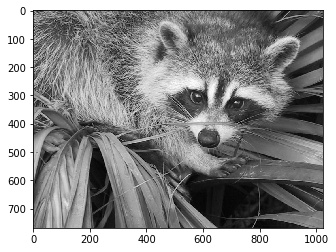

In [80]:
# if __name__ == "__main__":
#     # Parse argument (image)
#     argument_parser = argparse.ArgumentParser()
#     argument_parser.add_argument('-i', '--image',
#                                  help='path to image file',
#                                  default='.//raccoon.jpg')
#     arguments = vars(argument_parser.parse_args())
#     # Read image
#     image = cv2.imread(arguments['image'], 0).astype(int)  # load pix-mapped image

# +++
# to show image in the same window as a code
%matplotlib inline

image = cv2.imread('.//raccoon.jpg', 0).astype(int)  # manual load pix-mapped image
                                        # instead of arguments parsing for image load 
plt.imshow(image, cmap='gray') # show the image below in gray
plt.show()  
#+++

In [81]:
from pprint import pprint # +++

with open("frame_of_patterns_2.csv", "w") as csvFile:  # +++
    write = csv.writer(csvFile, delimiter=",")        # +++
    fieldnames = ("L=", "I=", "D=", "M=", "x0=")      # +++
    write.writerow(fieldnames)                        # +++

assert image is not None, "No image in the path"
image = image.astype(int)

start_time = time()
# Main
frame_of_patterns_ = cross_comp(image)  # returns Pm__
pprint(frame_of_patterns_[0]) # to show the output results in the convinient way +++ 


fline_PPs = 0
if fline_PPs:  # debug line_PPs_draft
    from line_PPs_draft import *
    frame_PP_ = []

    for y, P_ in enumerate(frame_of_patterns_):
        PPm_, PPd_ = search(P_)
        frame_PP_.append([PPm_, PPd_])

end_time = time() - start_time

[CP(L=2, I=434, D=42, M=-12, x0=0),
 CP(L=33, I=5928, D=-70, M=307, x0=0),
 CP(L=2, I=304, D=34, M=-4, x0=2),
 CP(L=14, I=3383, D=57, M=109, x0=35),
 CP(L=2, I=678, D=40, M=-10, x0=37),
 CP(L=2, I=769, D=-1, M=19, x0=51),
 CP(L=1, I=357, D=-21, M=-6, x0=53),
 CP(L=1, I=322, D=-14, M=1, x0=55),
 CP(L=2, I=541, D=-37, M=-7, x0=56),
 CP(L=22, I=4431, D=-29, M=179, x0=57),
 CP(L=2, I=264, D=-50, M=-20, x0=59),
 CP(L=1, I=69, D=-7, M=8, x0=81),
 CP(L=3, I=465, D=89, M=-44, x0=83),
 CP(L=2, I=474, D=-10, M=16, x0=84),
 CP(L=1, I=205, D=-15, M=0, x0=87),
 CP(L=12, I=1896, D=-20, M=94, x0=89),
 CP(L=2, I=380, D=42, M=-12, x0=90),
 CP(L=7, I=1709, D=25, M=78, x0=102),
 CP(L=1, I=264, D=-20, M=-5, x0=104),
 CP(L=5, I=962, D=-32, M=19, x0=111),
 CP(L=2, I=481, D=57, M=-27, x0=112),
 CP(L=3, I=902, D=-8, M=19, x0=117),
 CP(L=2, I=476, D=-38, M=-8, x0=119),
 CP(L=3, I=585, D=-1, M=34, x0=122),
 CP(L=1, I=226, D=26, M=-11, x0=124),
 CP(L=15, I=3974, D=6, M=137, x0=127),
 CP(L=1, I=240, D=-24, M=-9, 

In [82]:
print(end_time)

15.614576578140259


In [83]:
import pandas as pd
dataframe1 = pd.read_csv("frame_of_patterns_2.csv") # this file has been previously created 
                                            # in the modified form_Pm_ function
dataframe1

,L=,I=,D=,M=,x0=
0,2,434,42,-12.0,0
1,33,5928,-70,307.0,0
2,2,304,34,-4.0,2
3,14,3383,57,109.0,35
4,2,678,40,-10.0,37
...,...,...,...,...,...
127530,3,411,-91,-46.0,774
127531,195,8039,15,2646.0,775
127532,3,407,63,-18.0,778
127533,47,12100,32,569.0,973


### As you can see, the content of the array above corresponds to the content of the frame_of_patterns_ structure. But now it is more convenient to visualize data. In the first attempt it could look like this:

Text(0.5, 1.0, 'variable L =')

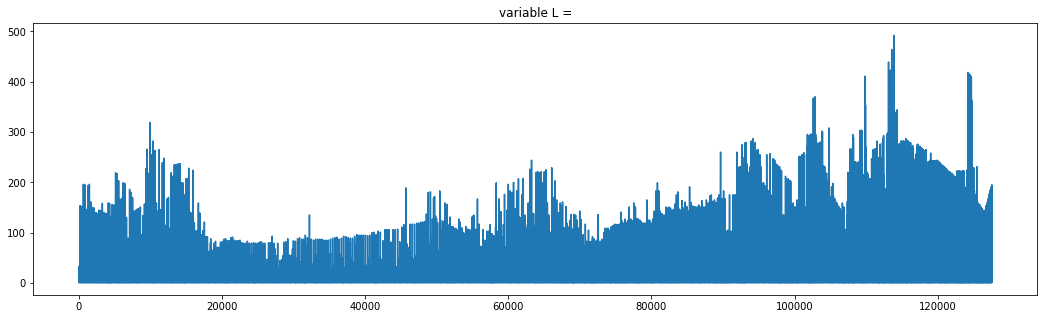

In [84]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (18,5)
plt.plot(dataframe1.iloc[:,0])
plt.title("variable L =")

### Let see, how these parameters values were changed since the previous version of the 1D algorithm

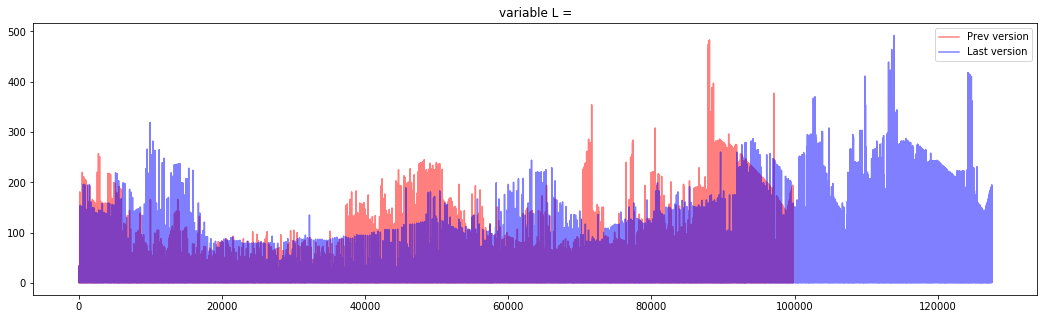

In [86]:
dataframe_prev = pd.read_csv("frame_of_patterns_.csv") # this file has been previously created 

plt.plot(dataframe_prev.iloc[:,0], 'r-', alpha=0.5, label='Prev version')
plt.plot(dataframe1.iloc[:,0], 'b-', alpha=0.5, label='Last version')
plt.title("variable L =")
plt.legend()

### Continue comparing other parameters:

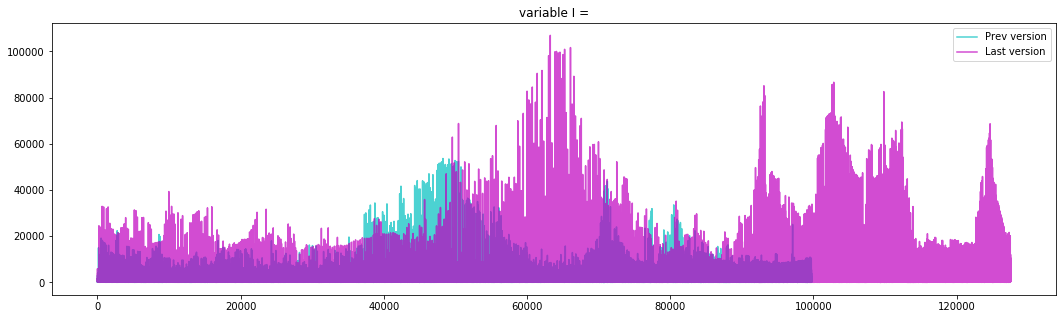

In [96]:
plt.plot(dataframe_prev.iloc[:,1], 'c-', alpha=0.7, label='Prev version')
plt.plot(dataframe1.iloc[:,1], 'm-', alpha=0.7, label='Last version')
plt.title("variable I =")
plt.legend()

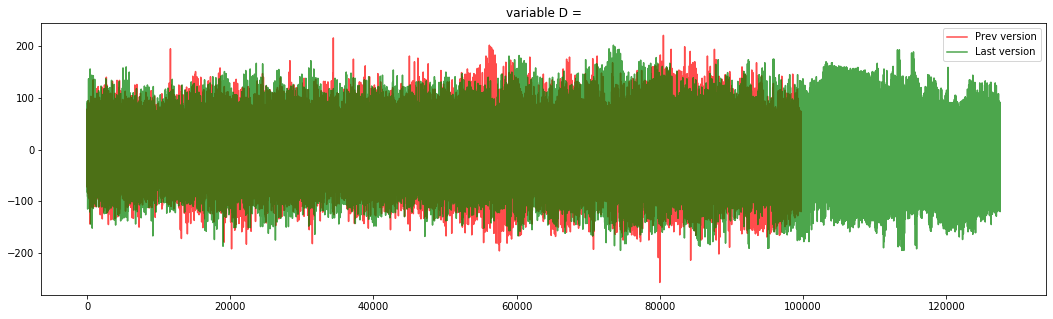

In [97]:
plt.plot(dataframe_prev.iloc[:,2], 'r-', alpha=0.7, label='Prev version')
plt.plot(dataframe1.iloc[:,2], 'g-', alpha=0.7, label='Last version')
plt.title("variable D =")
plt.legend()

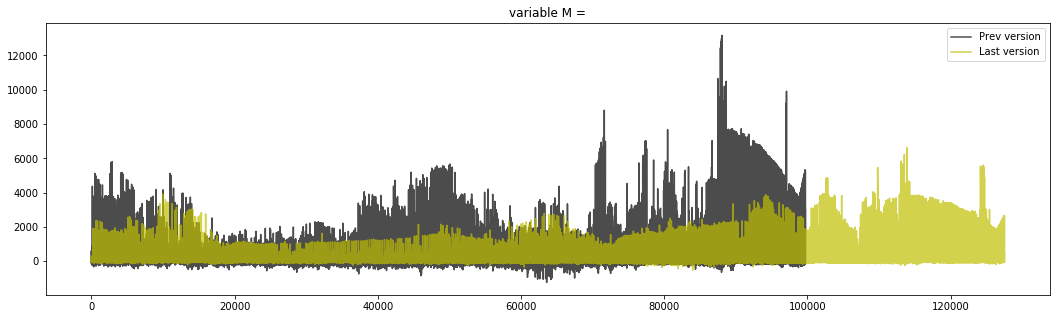

In [99]:
plt.plot(dataframe_prev.iloc[:,3], 'k-', alpha=0.7, label='Prev version')
plt.plot(dataframe1.iloc[:,3], 'y-', alpha=0.7, label='Last version')
plt.title("variable M =")
plt.legend()

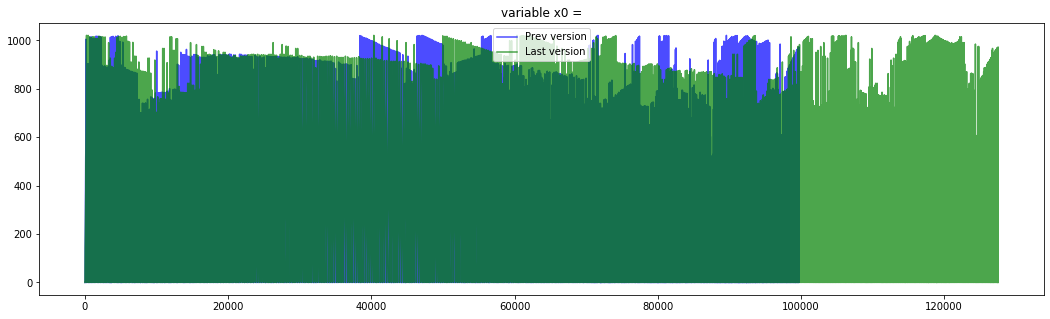

In [106]:
plt.plot(dataframe_prev.iloc[:,4], 'b-', alpha=0.7, label='Prev version')
plt.plot(dataframe1.iloc[:,4], 'g-', alpha=0.7, label='Last version')
plt.title("variable x0 =")
plt.legend()